In [2]:
#import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
import pandas as pd
import geopandas as gpd
from datetime import date
from shapely.geometry import Point, Polygon, MultiPolygon 
from shapely.ops import unary_union
import sys
sys.path.insert(0, '/projects/fireatlas_nrt/')
import FireMain, FireGpkg, FireGpkg_sfs, FireIO

In [4]:
s3.ls("s3://maap-ops-workspace/shared/gsfc_landslides/FEDSinput/static_sources/")

['maap-ops-workspace/shared/gsfc_landslides/FEDSinput/static_sources/',
 'maap-ops-workspace/shared/gsfc_landslides/FEDSinput/static_sources/README.txt',
 'maap-ops-workspace/shared/gsfc_landslides/FEDSinput/static_sources/VIIRS_Global_flaring_d.7_slope_0.029353_2017_web_v1.csv']

In [4]:
shape = pd.read_csv("s3://maap-ops-workspace/shared/gsfc_landslides/FEDSinput/static_sources/VIIRS_Global_flaring_d.7_slope_0.029353_2017_web_v1.csv")

shape =  gpd.GeoDataFrame(shape, geometry=gpd.points_from_xy(shape['Longitude'], shape['Latitude']))
#shape

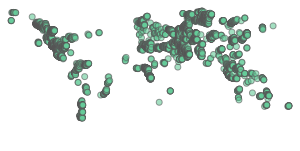

In [5]:
shape = shape.set_crs("EPSG:4326")

shape2 = shape.dropna().geometry
static_sources = unary_union(shape2.geometry) # Make all points into a sinlge shape 
static_sources

In [54]:
firesrc = "SNPP"  # source - ['SNPP', 'NOAA20', 'VIIRS', 'BAMOD']:
firenrt = False # NRT - True, False
firessr = "viirs"  # sensor - 'mcd64'
#print(df)

tst = (2019, 5, 1, "PM")
ted = (2019, 5, 3, "PM")

region = ("Static_sources", static_sources)



In [55]:
t = tst

sat="SNPP"

d = date(*t[:-1])
if sat == "SNPP":
    sathead = "VNP14IMGML"
elif sat == "NOAA20":
    sathead = "VJ114IMGML"
else:
    print("please set SNPP or NOAA20 for sat")

df = None

Temporary file not found: s3://maap-ops-workspace/shared/gsfc_landslides/FEDStemp-s3-conus/Static_sources_VNP14IMGML.201905.pkl.


In [ ]:
# if no pre-saved file, read from original VNP14IMGML file and do/save spatial filtering
if df is None:
    # read or form shape used for filtering active fires
    shp_Reg = FireIO.get_reg_shp(region[1])

    # read VJ114IMGML monthly file
    if sat == "SNPP":
        df = FireIO.read_VNP14IMGML(t[0], t[1])
        df = df.loc[df["Type"] == 0]  # type filtering
    elif sat == "NOAA20":
        df = FireIO.read_VJ114IMGML(t[0], t[1])
        df = df.loc[df["mask"] >= 7]
    else:
        print("please set SNPP or NOAA20 for sat")

    # do regional filtering
    df = FireIO.AFP_regfilter(df, shp_Reg) ### Where the issue is. 
    print(df)
    if len(df) == 0:
        print("killed at filter")
    # set ampm
    df = FireIO.AFP_setampm(df)
    if len(df) == 0:
        print("killed at am pm")


# add the satellite information
df["Sat"] = sat
df # A dataframe of static sources for the specific day. 


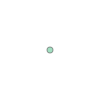